# **1. Importação das bibliotecas requeridas**

In [1]:
# é preciso converter o dataset para RecordIO format para o Linear Learner entender
import io 

import pandas as pd
import numpy as np
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Bibliotecas aws/sagemaker
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.amazon.amazon_estimator import image_uris
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.amazon.amazon_estimator import get_image_uri

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# **2. Carregando dados da AWS**

### **Buscando objetos no Glue Catalog**

In [2]:
glue_client = boto3.client('glue')

database_list = glue_client.get_databases()
database_list

{'DatabaseList': [{'Name': 'database_platform',
   'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 50, tzinfo=tzlocal()),
   'CreateTableDefaultPermissions': [{'Principal': {'DataLakePrincipalIdentifier': 'IAM_ALLOWED_PRINCIPALS'},
     'Permissions': ['ALL']}],
   'CatalogId': '793574898187'},
  {'Name': 'sampledb',
   'Description': 'Sample database',
   'Parameters': {'CreatedBy': 'Athena', 'EXTERNAL': 'TRUE'},
   'CreateTime': datetime.datetime(2021, 4, 6, 11, 30, 13, tzinfo=tzlocal()),
   'CreateTableDefaultPermissions': [{'Principal': {'DataLakePrincipalIdentifier': 'IAM_ALLOWED_PRINCIPALS'},
     'Permissions': ['ALL']}],
   'CatalogId': '793574898187'}],
 'ResponseMetadata': {'RequestId': '1c9317ef-f160-47fd-8c1d-e03415ba9dc3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 07 Apr 2021 12:13:53 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '578',
   'connection': 'keep-alive',
   'x-amzn-requestid': '1c9317ef-f160-47fd-8c1d-e03415ba9dc

In [3]:
database_name_platform = 'database_platform'

for i in range(len(database_list['DatabaseList'])):
    if database_list['DatabaseList'][i]['Name'] == database_name_platform:
        database_glue = database_list['DatabaseList'][i]

In [4]:
database_glue

{'Name': 'database_platform',
 'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 50, tzinfo=tzlocal()),
 'CreateTableDefaultPermissions': [{'Principal': {'DataLakePrincipalIdentifier': 'IAM_ALLOWED_PRINCIPALS'},
   'Permissions': ['ALL']}],
 'CatalogId': '793574898187'}

In [5]:
table_list = glue_client.get_tables(CatalogId=database_glue['CatalogId'],
                                    DatabaseName=database_glue['Name']
)

table_list

{'TableList': [{'Name': 'cleaned',
   'DatabaseName': 'database_platform',
   'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
   'UpdateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
   'Retention': 0,
   'StorageDescriptor': {'Columns': [{'Name': 'id',
      'Type': 'string',
      'Comment': '',
      'Parameters': {}},
     {'Name': 'name', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'abv', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'ibu', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'target_fg', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'target_og', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'ebc', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'srm', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'ph', 'Type': 'string', 'Comment': '', 'Parameters': {}}],
    'Location': 's3://cleaned-buc

In [6]:
table_name = 'cleaned'

for i in range(len(table_list['TableList'])):
    if table_list['TableList'][i]['Name'] == table_name:
        table_glue_cleaned = table_list['TableList'][i]

table_glue_cleaned

{'Name': 'cleaned',
 'DatabaseName': 'database_platform',
 'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
 'UpdateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
 'Retention': 0,
 'StorageDescriptor': {'Columns': [{'Name': 'id',
    'Type': 'string',
    'Comment': '',
    'Parameters': {}},
   {'Name': 'name', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'abv', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'ibu', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'target_fg', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'target_og', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'ebc', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'srm', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'ph', 'Type': 'string', 'Comment': '', 'Parameters': {}}],
  'Location': 's3://cleaned-bucket-platform/processing-sucess',
  'InputFormat':

In [7]:
s3_location_table = table_glue_cleaned['StorageDescriptor']['Location']
s3_location_table

's3://cleaned-bucket-platform/processing-sucess'

In [8]:
bucket_name = s3_location_table.split('/')[2]
folder_data = s3_location_table.split('/')[3]

print(bucket_name)
print(folder_data)

cleaned-bucket-platform
processing-sucess


### **Capturando dados do bucket S3**

Será feito uma busca por dados que estão no diretório "bucket_name/processing-sucess".

In [9]:
s3_client = boto3.client('s3')

In [10]:
# Obtendo uma lista de objetos do bucket
obj_list = s3_client.list_objects(Bucket=bucket_name)

files=[]
for contents in obj_list['Contents']:
    if contents['Key'].split('/')[0].split('/')[0] == folder_data:
        files.append(contents['Key'])
    
print(len(files))

188


In [11]:
# Visualizar um exemplo do dado
file_name=files[0]

print(file_name)

processing-sucess/202104061114_clean.csv


In [12]:
# captura um objeto do S3 como exemplo para visualizar os metadados 
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# visualizando o conteúdo do objeto
display(data_object)

{'ResponseMetadata': {'RequestId': 'H1Y5Y1VS706ZRERB',
  'HostId': 'CWGkSoqStUkrsx4lAAPAQY0K/Twukz20k7NgYB2KqeyAZiT6Tgqk/LOBR2hcdhbVdGeA3Y7dnOU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CWGkSoqStUkrsx4lAAPAQY0K/Twukz20k7NgYB2KqeyAZiT6Tgqk/LOBR2hcdhbVdGeA3Y7dnOU=',
   'x-amz-request-id': 'H1Y5Y1VS706ZRERB',
   'date': 'Wed, 07 Apr 2021 12:14:01 GMT',
   'last-modified': 'Tue, 06 Apr 2021 11:14:22 GMT',
   'etag': '"327764b0082a63b8c9cf3a7317bf75e8"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'content-length': '51',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 4, 6, 11, 14, 22, tzinfo=tzutc()),
 'ContentLength': 51,
 'ETag': '"327764b0082a63b8c9cf3a7317bf75e8"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7ffb47b732b0>}

In [13]:
# Verificando o tipo de dados da chave "Body" para leitura posterior
data_body = data_object["Body"].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


* É do tipo de dado `bytes`, para realizar a leitura devemos utilizar [io.BytesIO(file)](https://docs.python.org/3/library/io.html#binary-i-o).

In [14]:
# Leitura dos dados no formato bytes
data_stream = io.BytesIO(data_body)

### **Criação do DataFrame com os dados do S3**

In [15]:
list_columns = ['id', 'name', 'abv', 'ibu', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']

# Criando dicionário de chave e tipo para a criação do DataFrame
dict_type    = {'id': 'int32', 'name': 'string', 'abv': 'float32', 'ibu': 
                'float32', 'target_fg': 'float32', 'target_og': 'float32', 
                'ebc': 'float32', 'srm': 'float32', 'ph': 'float32'}

df = pd.DataFrame(columns=list_columns)

for file in files:

    # obtendo um objeto s3
    data_object = s3_client.get_object(Bucket=bucket_name, Key=file)
    
    # lendo os dados da chave "Body"
    data_body = data_object["Body"].read()
    
    # lendo dados em bytes
    data_stream = io.BytesIO(data_body)
    
    counties_df = pd.read_csv(data_stream, names=list_columns, dtype=dict_type, header=None, delimiter=",") 

    df = counties_df.append(df, ignore_index=True)

df.head()

,id,name,abv,ibu,target_fg,target_og,ebc,srm,ph
0,100,Elvis Juice V2.0 - Prototype Challenge,6.5,60.0,1010.0,1060.0,25.0,12.5,4.4
1,186,Jasmine IPA,5.8,40.0,1014.0,1060.0,35.0,17.5,4.4
2,118,Bounty Hunter - Shareholder Brew,6.5,35.0,1020.0,1068.0,250.0,125.0,4.2
3,208,Sunshine On Rye - B-Sides,7.2,130.0,1010.0,1065.0,14.0,7.0,5.2
4,305,Native Son,8.5,70.0,1010.0,1073.0,18.0,9.0,4.6


In [16]:
# Exibindo as colunas do dataframe
df.columns

Index(['id', 'name', 'abv', 'ibu', 'target_fg', 'target_og', 'ebc', 'srm',
       'ph'],
      dtype='object')

### **Excluindo as colunas não utilizadas para a modelagem**

In [17]:
df.drop(columns=['id', 'name'], axis=1, inplace=True)

In [18]:
df.head()

,abv,ibu,target_fg,target_og,ebc,srm,ph
0,6.5,60.0,1010.0,1060.0,25.0,12.5,4.4
1,5.8,40.0,1014.0,1060.0,35.0,17.5,4.4
2,6.5,35.0,1020.0,1068.0,250.0,125.0,4.2
3,7.2,130.0,1010.0,1065.0,14.0,7.0,5.2
4,8.5,70.0,1010.0,1073.0,18.0,9.0,4.6


In [19]:
df.tail()

,abv,ibu,target_fg,target_og,ebc,srm,ph
183,4.5,37.0,1012.0,1047.0,20.0,10.0,4.2
184,8.2,70.0,1013.0,1076.0,16.0,8.0,4.4
185,6.7,67.0,1013.0,1064.0,19.0,9.5,4.4
186,13.2,85.0,1023.0,1125.0,140.0,71.0,4.4
187,4.4,70.0,1012.0,1045.0,30.0,15.0,4.4


**Excluindo dados duplicados**

In [20]:
df.drop_duplicates(inplace=True)

**Verificando se existem dados nulos ou NaN**

In [21]:
df.isnull().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          1
srm          1
ph           0
dtype: int64

In [22]:
df.isna().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          1
srm          1
ph           0
dtype: int64

**Como existem os mesmos dados nulos e NaN para as mesmas colunas e com a mesma quantidade, vou excluir**

In [23]:
df.dropna(inplace=True)

In [24]:
df.isnull().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

In [25]:
df.isna().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

In [26]:
# reiniciando a contagem dos indexes após a exclusão de dados nulos e/ou ausentes
df.reset_index(drop=True, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   abv        126 non-null    float32
 1   ibu        126 non-null    float32
 2   target_fg  126 non-null    float32
 3   target_og  126 non-null    float32
 4   ebc        126 non-null    float32
 5   srm        126 non-null    float32
 6   ph         126 non-null    float32
dtypes: float32(7)
memory usage: 3.6 KB


In [28]:
df.describe()

,abv,ibu,target_fg,target_og,ebc,srm,ph
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,7.690478,68.031746,1015.039673,1067.192139,69.699203,35.144608,4.446032
std,3.965843,107.769676,13.657174,27.675142,97.635040,49.288284,0.357916
min,2.500000,0.000000,1000.000000,1007.000000,8.000000,4.000000,3.200000
25%,5.200000,32.750000,1010.000000,1048.000000,15.000000,8.000000,4.400000
50%,7.150000,50.000000,1011.000000,1065.000000,30.000000,15.000000,4.400000
75%,8.500000,70.000000,1015.750000,1076.750000,70.750000,35.750000,4.400000
max,32.000000,1157.000000,1120.000000,1157.000000,600.000000,305.000000,5.300000


## **3. Análise Exploratória dos Dados (EDA)**

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


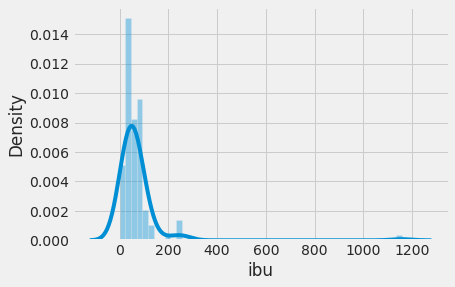

In [29]:
sns.distplot(df['ibu']);

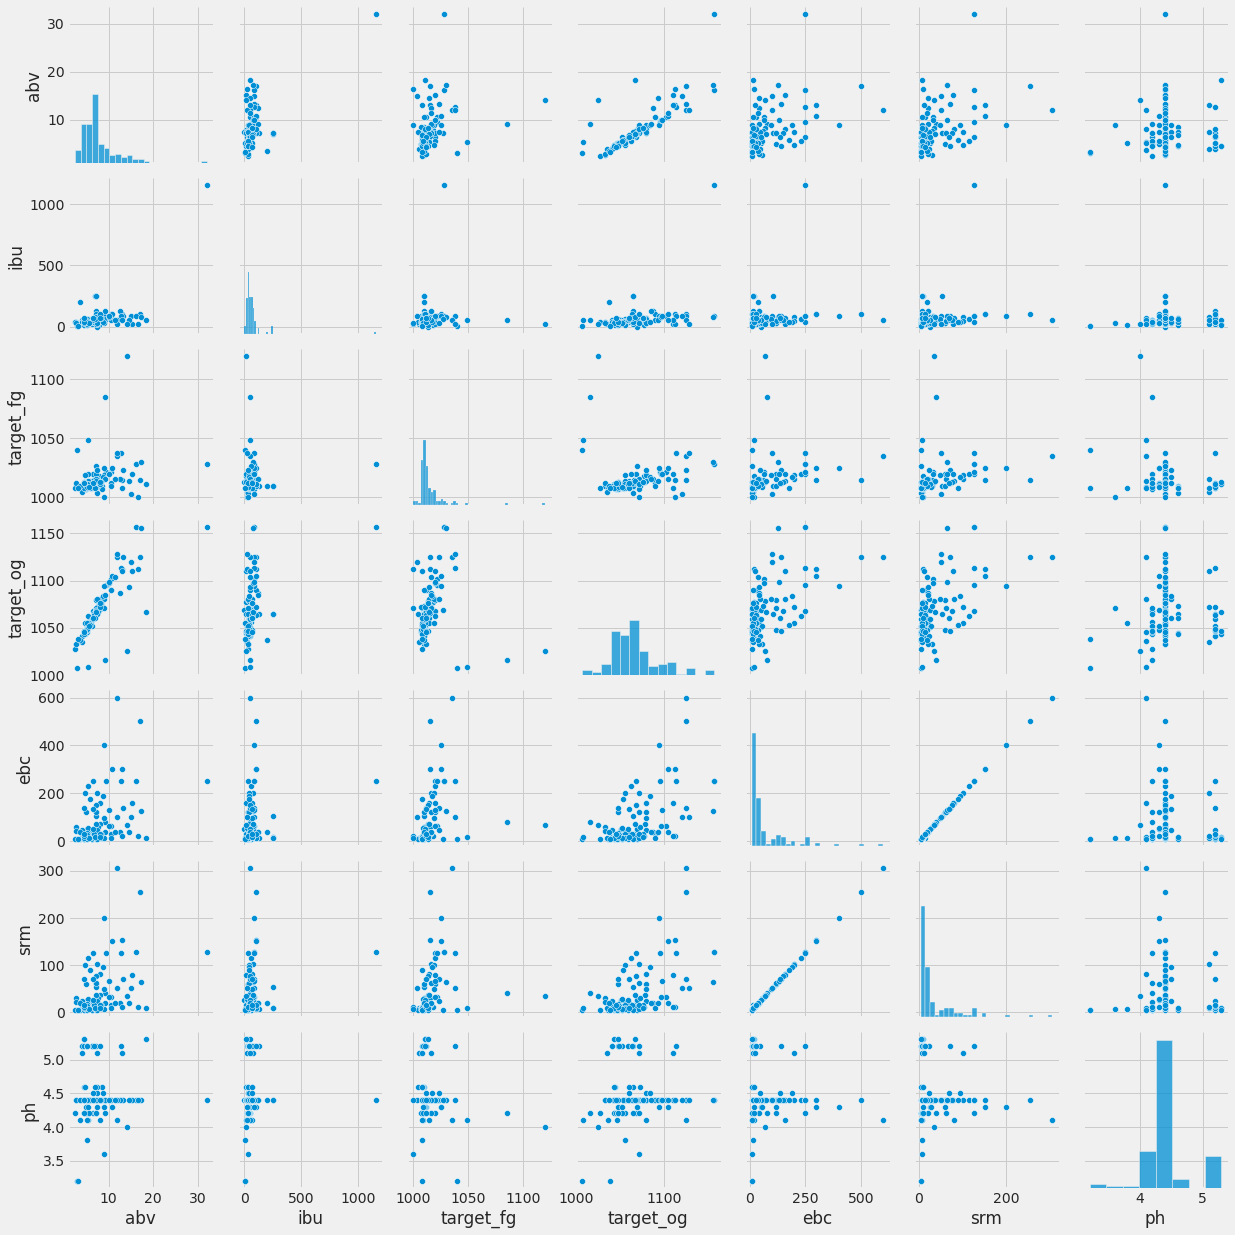

In [30]:
sns.pairplot(df);

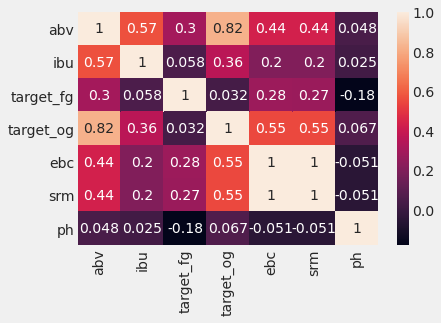

In [31]:
# Verificando a correlação dos dados
sns.heatmap(df.corr(), annot=True);

# **4. Pré-processamento dos dados**

#### **Selecionando as features e o target para o treinamento do modelo**

In [32]:
# Selecionando as features
features_names = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']
features = df[features_names]

target = df['ibu']

In [33]:
len(features_names)

6

In [34]:
features.head()

,abv,target_fg,target_og,ebc,srm,ph
0,6.5,1010.0,1060.0,25.0,12.5,4.4
1,5.8,1014.0,1060.0,35.0,17.5,4.4
2,6.5,1020.0,1068.0,250.0,125.0,4.2
3,7.2,1010.0,1065.0,14.0,7.0,5.2
4,8.5,1010.0,1073.0,18.0,9.0,4.6


In [35]:
target.head()

0     60.0
1     40.0
2     35.0
3    130.0
4     70.0
Name: ibu, dtype: float32

In [36]:
X = np.array(features).astype('float32')
y = np.array(target).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [37]:
X_train.shape

(100, 6)

In [38]:
X_train

array([[   7.  , 1010.  , 1065.  ,   15.  ,    7.5 ,    4.4 ],
       [   9.2 , 1085.  , 1016.  ,   78.8 ,   40.  ,    4.2 ],
       [   5.2 , 1011.  , 1048.  ,   35.  ,   17.5 ,    4.4 ],
       [   8.2 , 1013.  , 1076.  ,   16.  ,    8.  ,    4.4 ],
       [   5.5 , 1020.  , 1062.  ,  230.  ,  115.  ,    4.4 ],
       [   4.5 , 1011.  , 1045.  ,   20.  ,   10.  ,    4.2 ],
       [   4.1 , 1010.  , 1041.7 ,   15.  ,   15.  ,    4.4 ],
       [   5.2 , 1010.  , 1048.  ,   16.  ,    8.  ,    5.2 ],
       [   4.5 , 1012.  , 1047.  ,   20.  ,   10.  ,    4.2 ],
       [  17.  , 1015.  , 1125.  ,  500.  ,  254.  ,    4.4 ],
       [   5.6 , 1011.  , 1055.  ,   15.  ,    7.6 ,    4.4 ],
       [   6.  , 1010.  , 1056.  ,   17.  ,    8.5 ,    4.4 ],
       [  12.  , 1035.  , 1125.  ,  600.  ,  305.  ,    4.1 ],
       [   7.2 , 1010.  , 1065.  ,   17.  ,    8.5 ,    4.4 ],
       [  10.  , 1020.  , 1098.  ,  130.  ,   65.  ,    4.4 ],
       [   7.5 , 1013.  , 1068.  ,   30.  ,   15.  ,   

### **4.1 Upload dados pré-processados para o S3**

Nesta etapa se faz necessário, após o tratamento dos dados, realizar o upload dos dados no s3 para a posterior leitura e treinamento do modelo.

In [39]:
# Criando sessão SageMaker
sagemaker_session = sagemaker.Session()

# Prefixo para o diretório no bucket S3
prefix = 'model-sagemaker'

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::793574898187:role/service-role/AmazonSageMaker-ExecutionRole-20210404T150765


In [40]:
# Criação de um objeto bytes para trabalhar como buffer
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

# Sub-pasta para o arquivo de treinamento que será enviado ao S3 
key = 'linear-train-data'

# Upload arquivo de dado para o S3
boto3.resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket_name, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://cleaned-bucket-platform/model-sagemaker/train/linear-train-data


In [41]:
# Criação de um objeto bytes para trabalhar como buffer
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

# Sub-pasta para o arquivo de treinamento que será enviado ao S3 
key = 'linear-test-data'

boto3.resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket_name, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://cleaned-bucket-platform/model-sagemaker/test/linear-test-data


In [42]:
# Sub-pasta para os artefatos de saída do modelo, exemplo: modelo treinado
output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://cleaned-bucket-platform/model-sagemaker/output


# **5. Treinamento do Modelo**

* Linear Learner (Linear Regression)

In [43]:
container = image_uris.retrieve('linear-learner', 
                                boto3.Session().region_name)

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

In [44]:
linear.set_hyperparameters(feature_dim = len(features_names),
                           predictor_type = 'regressor',
                           mini_batch_size = 20,
                           epochs = 5,
                           num_models = 10,
                           loss = 'absolute_loss')

In [45]:
# job_name = "sagemaker-linear-learner-" + strftime("%H-%M-%S", gmtime())
# print("Training job", job_name)

In [46]:
%time
#Pass in S3 training_data path variable we declared earlier
# linear.fit({'train': s3_train_data}, job_name=job_name)
linear.fit({'train': s3_train_data})

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
2021-04-07 12:15:44 Starting - Starting the training job...
2021-04-07 12:15:46 Starting - Launching requested ML instancesProfilerReport-1617797744: InProgress
......
2021-04-07 12:16:58 Starting - Preparing the instances for training......
2021-04-07 12:17:58 Downloading - Downloading input data...
2021-04-07 12:18:45 Training - Training image download completed. Training in progress.
2021-04-07 12:18:45 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/07/2021 12:18:43 INFO 140555040532288] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_model

# **6. Deploy do Modelo e Criação de Endpoint**

Para que seja possível realizar inferências no modelo linear learner é preciso fazer o seu deploy.

In [47]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

-------------!

Observe que também serializamos nosso modelo para garantir que possamos processar nossos resultados e compará-los com os resultados reais do teste Y. Depois que seu endpoint tiver sido criado com sucesso, você deverá ver uma mensagem de exclamação e um endpoint aparecerá quando você verificar Endpoints ativos no serviço SageMaker.

In [49]:
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

In [50]:
linear_regressor.endpoint_name

'linear-learner-2021-04-07-00-49-57-095'

# **7. Inferência do Modelo**

In [ ]:
pred_test = linear_regressor.predict(X_test)
pred_train = linear_regressor.predict(X_train)

In [ ]:
pred_test

In [ ]:
# Iterando o result json para um NP Array para todas as inferências e para comparar com y_test
predictions_test = np.array([res['score'] for res in pred_test['predictions']])
predictions_test # np_array

In [ ]:
# Iterando o result json para um NP Array para todas as inferências e para comparar com y_test
predictions_train = np.array([res['score'] for res in pred_train['predictions']])
predictions_train # np_array

In [ ]:
y_test

# **8. Avaliação do Modelo**

Funções para avaliar o modelo treinado

In [216]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [217]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, predictions_train)
print('\n*************************************\n')
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predictions_test)

Train set evaluation:
_____________________________________
MAE: 37.982853412628174
MSE: 18131.63677899512
RMSE: 134.6537663008173
R2 Square 0.09954175082775352

*************************************

Test set evaluation:
_____________________________________
MAE: 26.83193588256836
MSE: 2692.909498392837
RMSE: 51.8932509907872
R2 Square -0.0051543319715472435


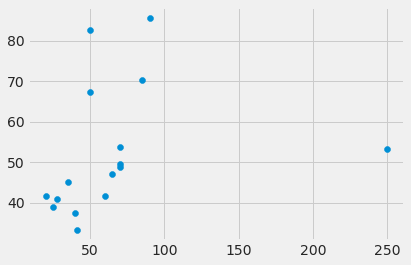

In [218]:
plt.scatter(y_test, predictions_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


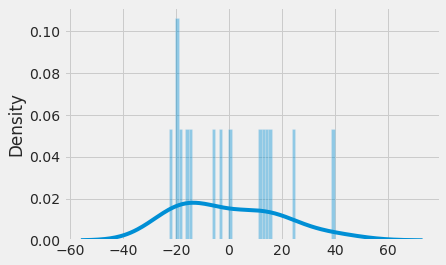

In [160]:
sns.distplot((y_test - predictions_test), bins=50);

# **9. Excluindo Endpoint**

Exclua o endpoint ao final do uso para evitar cobranças

In [51]:
sagemaker.Session().delete_endpoint(linear_regressor.endpoint_name)
print(f"deleted {linear_regressor.endpoint_name} successfully!")

deleted linear-learner-2021-04-07-00-49-57-095 successfully!
